# Energy-Based models and structured prediction

In this assignment we're going to work with structured prediction. Structured prediction broadly refers to any problem involving predicting structured values, as opposed to plain scalars. Examples of structured outputs include graphs and text.

We're going to work with text. The task is to transcribe a word from an image. The difficulty here is that different words have different lengths, so we can't just have fixed number of outputs.

Furthermore, we will be comparing model trained with our DP solution to model trained with GTN framework.

# GTN Framework

GTN framework has support for finding Viterbi paths and training the prediction. The below links can be helpful in solving this homework\:
- [CTC](https://distill.pub/2017/ctc/)
- [Weighted Automata in ML](https://awnihannun.com/writing/automata_ml/automata_in_machine_learning.pdf)

Additional Links\:
- [GTN Documentation](https://gtn.readthedocs.io/en/latest/)
- [GTN Applications](https://github.com/facebookresearch/gtn_applications)

## Dataset
As always, the first thing to do is implementing the dataset. We're going to create a dataset that creates images of random words. We'll also include some augmentations, such as jitter (moving the character horizontally).

In [1]:
! mkdir fonts
! curl --output fonts/font.zip https://www.fontsquirrel.com/fonts/download/Anonymous
! unzip -n fonts/font.zip -d fonts

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29805  100 29805    0     0  40432      0 --:--:-- --:--:-- --:--:-- 40440
Archive:  fonts/font.zip
  inflating: fonts/Anonymous.ttf     
  inflating: fonts/Mark Simonson - Anonymous License.txt  


torch.Size([32, 18])
image for: q


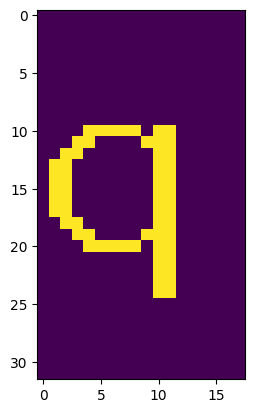

In [2]:
from PIL import ImageDraw, ImageFont
import string
import random
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images
from matplotlib import pyplot as plt

simple_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                ])

class SimpleWordsDataset(torch.utils.data.IterableDataset):

  def __init__(self, max_length, len=100, jitter=False, noise=False):
    self.max_length = max_length
    self.transforms = transforms.ToTensor()
    self.len = len
    self.jitter = jitter
    self.noise = noise

  def __len__(self):
    return self.len

  def __iter__(self):
    for _ in range(self.len):
        text = ''.join([random.choice(string.ascii_lowercase) for i in range(self.max_length)])
        img = self.draw_text(text, jitter=self.jitter, noise=self.noise)
        yield img, text

  def draw_text(self, text, length=None, jitter=False, noise=False):
    if length == None:
        length = 18 * len(text)
    img = Image.new('L', (length, 32))
    fnt = ImageFont.truetype("fonts/Anonymous.ttf", 20)

    d = ImageDraw.Draw(img)
    pos = (0, 5)
    if jitter:
        pos = (random.randint(0, 7), 5)
    else:
        pos = (0, 5)
    d.text(pos, text, fill=1, font=fnt)

    img = self.transforms(img)
    img[img > 0] = 1

    if noise:
        img += torch.bernoulli(torch.ones_like(img) * 0.1)
        img = img.clamp(0, 1)


    return img[0]

sds = SimpleWordsDataset(1, jitter=True, noise=False)
img, text = next(iter(sds))
print(img.shape)
plt.imshow(img)
print(f'image for: {text}')

We can look at what the entire alphabet looks like in this dataset.

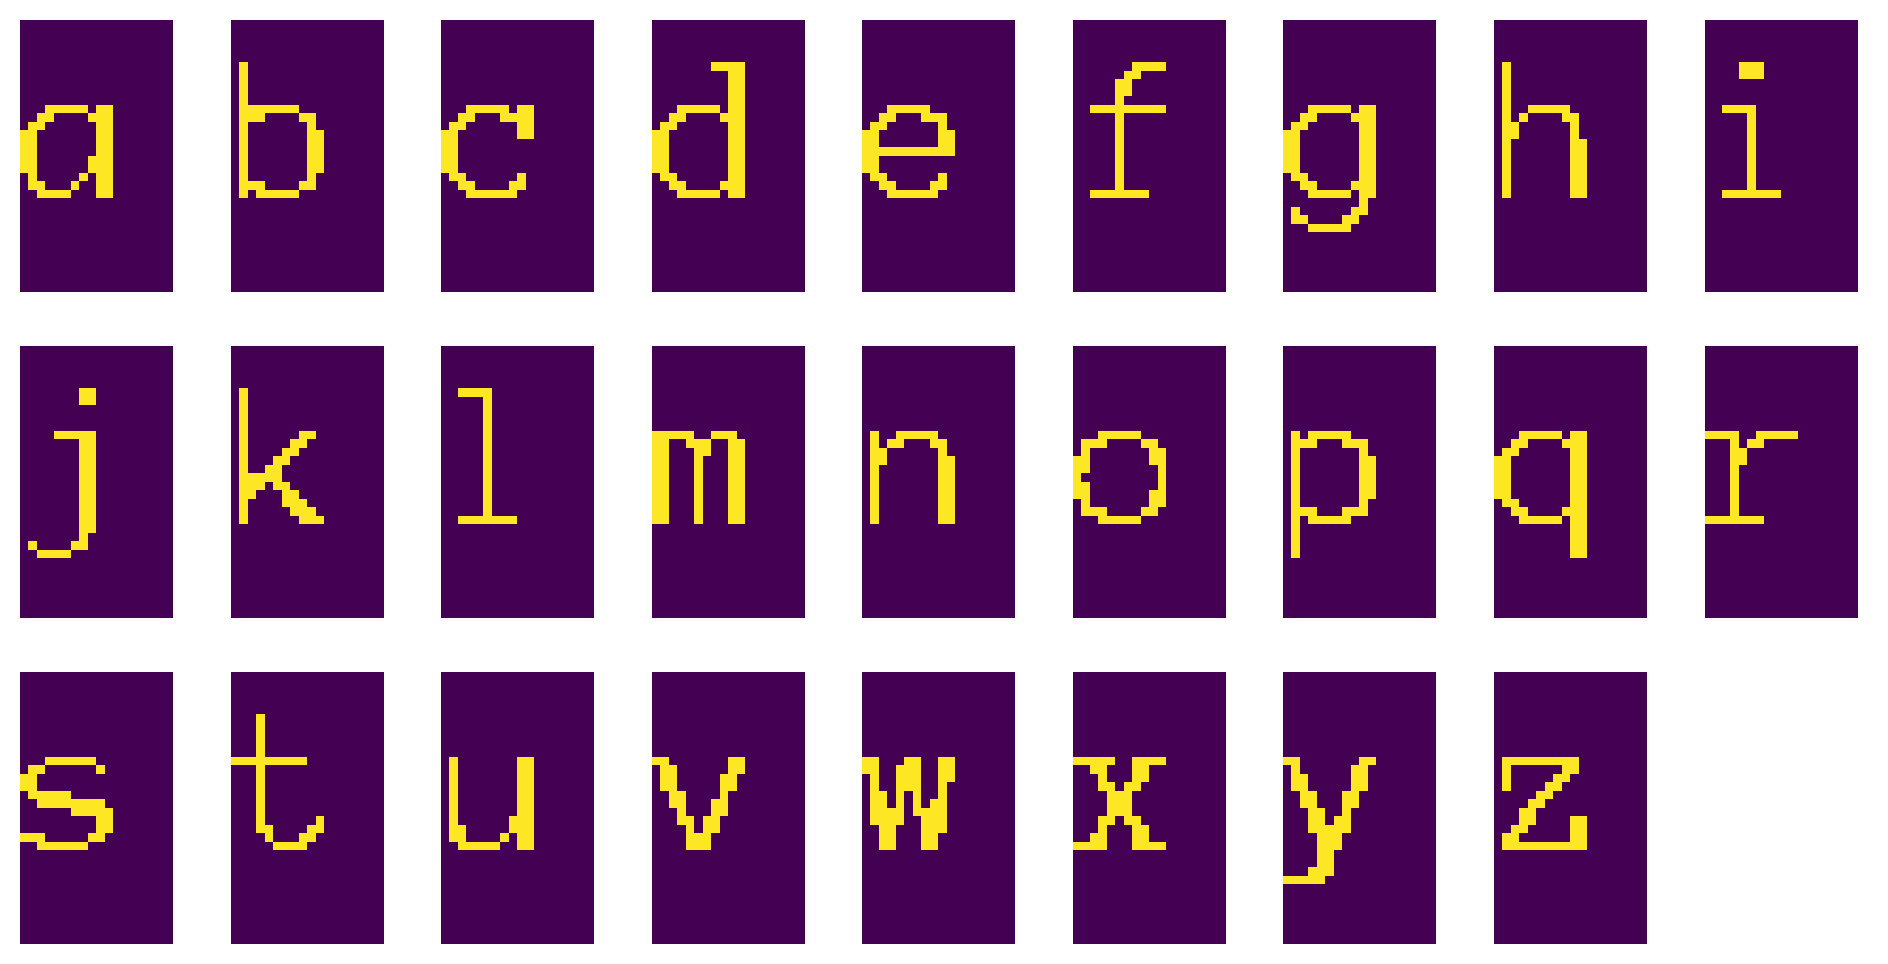

In [3]:
fig, ax = plt.subplots(3, 9, figsize=(12, 6), dpi=200)

for i, c in enumerate(string.ascii_lowercase):
    row = i // 9
    col = i % 9
    ax[row][col].imshow(sds.draw_text(c))
    ax[row][col].axis('off')
ax[2][8].axis('off')

plt.show()

We can also put the entire alphabet in one image.

(-0.5, 339.5, 31.5, -0.5)

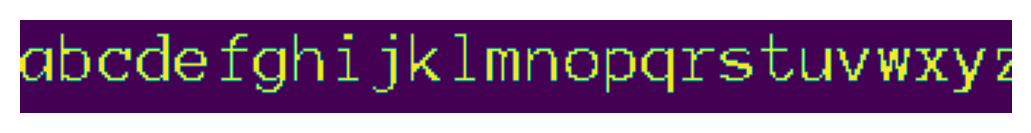

In [4]:
alphabet = sds.draw_text(string.ascii_lowercase, 340)
plt.figure(dpi=200)
plt.imshow(alphabet)
plt.axis('off')

## Model definition
Before we define the model, we define the size of our alphabet. Our alphabet consists of lowercase English letters, and additionally a special character used for space between symbols or before and after the word. For the first part of this assignment, we don't need that extra character.

Our end goal is to learn to transcribe words of arbitrary length. However, first, we pre-train our simple convolutional neural net to recognize single characters. In order to be able to use the same model for one character and for entire words, we are going to design the model in a way that makes sure that the output size for one character (or when input image size is 32x18) is 1x27, and Kx27 whenever the input image is wider. K here will depend on particular architecture of the network, and is affected by strides, poolings, among other things.
A little bit more formally, our model $f_\theta$, for an input image $x$ gives output energies $l = f_\theta(x)$. If $x \in \mathbb{R}^{32 \times 18}$, then $l \in \mathbb{R}^{1 \times 27}$.
If $x \in \mathbb{R}^{32 \times 100}$ for example, our model may output $l \in \mathbb{R}^{10 \times 27}$, where $l_i$ corresponds to a particular window in $x$, for example from $x_{0, 9i}$ to $x_{32, 9i + 18}$ (again, this will depend on the particular architecture).

Below is a drawing that explains the sliding window concept. We use the same neural net with the same weights to get $l_1, l_2, l_3$, the only difference is receptive field. $l_1$ is looks at the leftmost part, at character 'c', $l_2$ looks at 'a', and $l_3$ looks at 't'. The receptive field may or may not overlap, depending on how you design your convolutions.

![cat.png](https://i.imgur.com/JByfyKh.png)

In [5]:
# constants for number of classes in total, and for the special extra character for empty space
ALPHABET_SIZE = 27
BETWEEN = 26

In [53]:
from torch import nn

class SimpleNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(3072, 256)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(128, ALPHABET_SIZE)

    def forward(self, x):
        """
        Input x: (bs, 1, 32, k)
        after applying cnn_block, x.shape should be: (bs, alphabet_size, 1, width)
        """
        window_size = 4
        step_size = 18
        def process_window(window):
            window = self.conv1(window)
            window = self.bn1(window)
            window = self.relu1(window)
            window = self.conv2(window)
            window = self.bn2(window)
            window = self.relu2(window)
            window = self.conv3(window)
            window = self.bn3(window)
            window = self.relu3(window)
            flattened = window.view(window.size(0), -1)
            out = self.fc1(flattened)
            out = self.relu_fc1(out)
            out = self.fc2(out)
            out = self.relu_fc2(out)
            out = self.fc3(out)
            return out
        num_windows = (x.shape[-1] - step_size) // window_size + 1
        windows = [process_window(x[:, :, :, i:i + step_size]) for i in range(0, x.shape[-1] - step_size + 1, window_size)]
        return torch.stack(windows, dim=1)

Let's initalize the model and apply it to the alphabet image:

In [54]:
model = SimpleNet()

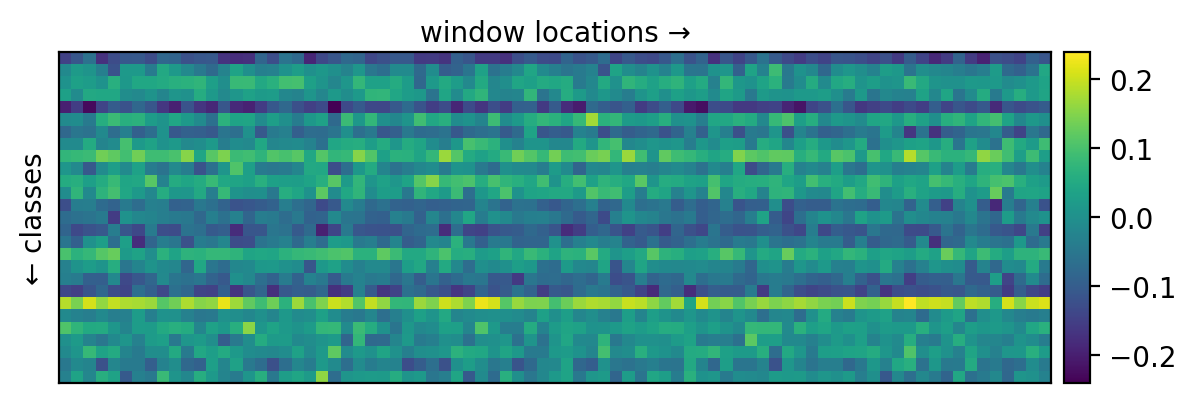

In [55]:
alphabet_energies = model(alphabet.view(1, 1, *alphabet.shape))

def plot_energies(ce):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(ce.cpu().T)

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← classes')
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks([])

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)

plot_energies(alphabet_energies[0].detach())

So far we only see random outputs, because the classifier is untrained.

## Train with one character

Now we train the model we've created on a dataset where images contain only single characters. Note the changed cross_entropy function.

In [56]:
def train_model(model, epochs, dataloader, criterion, optimizer):
  for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(dataloader):
      inputs, labels = inputs.cuda(), labels.cuda()
      optimizer.zero_grad()
      outputs = model(inputs.unsqueeze(1))
      loss = criterion(outputs[:, 0], labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if (batch_idx + 1) % 21 == 0:
          avg_loss = running_loss / 100
          print(f'Epoch [{epoch + 1}/{epochs}], '
                f'Batch [{batch_idx + 1}/{len(dataloader)}], '
                f'Loss: {avg_loss:.4f}')
          running_loss = 0.0

In [57]:
from tqdm.notebook import tqdm
import torch.optim as optim

def cross_entropy(energies, *args, **kwargs):
    """ We use energies, and therefore we need to use log soft arg min instead
        of log soft arg max. To do that we just multiply energies by -1. """
    return nn.functional.cross_entropy(-1 * energies, *args, **kwargs)

def simple_collate_fn(samples):
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(lambda c : torch.tensor(ord(c) - ord('a')), annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))

    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(1, len=1000, jitter=True, noise=False)
dataloader = torch.utils.data.DataLoader(sds, batch_size=16, num_workers=0, collate_fn=simple_collate_fn)

model.cuda()
# TODO: initialize optimizer, train the model on the one-character dataset
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
train_model(model, epochs, dataloader, cross_entropy, optimizer)

Epoch [1/100], Batch [21/63], Loss: 0.5975
Epoch [1/100], Batch [42/63], Loss: 0.3845
Epoch [1/100], Batch [63/63], Loss: 0.1600
Epoch [2/100], Batch [21/63], Loss: 0.0477
Epoch [2/100], Batch [42/63], Loss: 0.0078
Epoch [2/100], Batch [63/63], Loss: 0.0055
Epoch [3/100], Batch [21/63], Loss: 0.0041
Epoch [3/100], Batch [42/63], Loss: 0.0014
Epoch [3/100], Batch [63/63], Loss: 0.0008
Epoch [4/100], Batch [21/63], Loss: 0.0005
Epoch [4/100], Batch [42/63], Loss: 0.0003
Epoch [4/100], Batch [63/63], Loss: 0.0002
Epoch [5/100], Batch [21/63], Loss: 0.0002
Epoch [5/100], Batch [42/63], Loss: 0.0002
Epoch [5/100], Batch [63/63], Loss: 0.0002
Epoch [6/100], Batch [21/63], Loss: 0.0001
Epoch [6/100], Batch [42/63], Loss: 0.0001
Epoch [6/100], Batch [63/63], Loss: 0.0001
Epoch [7/100], Batch [21/63], Loss: 0.0001
Epoch [7/100], Batch [42/63], Loss: 0.0001
Epoch [7/100], Batch [63/63], Loss: 0.0001
Epoch [8/100], Batch [21/63], Loss: 0.0001
Epoch [8/100], Batch [42/63], Loss: 0.0001
Epoch [8/10

In [58]:
def get_accuracy(model, dataset):
    cnt = 0
    for i, l in dataset:
        energies = model(i.unsqueeze(0).unsqueeze(0).cuda())[0, 0]
        x = energies.argmin(dim=-1)
        cnt += int(x == (ord(l[0]) - ord('a')))
    return cnt / len(dataset)

tds = SimpleWordsDataset(1, len=100)
accuracy = get_accuracy(model, tds)
print(f'accuracy: {accuracy}')
assert accuracy == 1.0, 'Your model doesn\'t achieve near perfect accuracy for 1 character'

accuracy: 1.0


Now, to see how our model would work with more than one character, we apply the model to a bigger input - the image of the alphabet we saw earlier. We extract the energies for each window and show them.

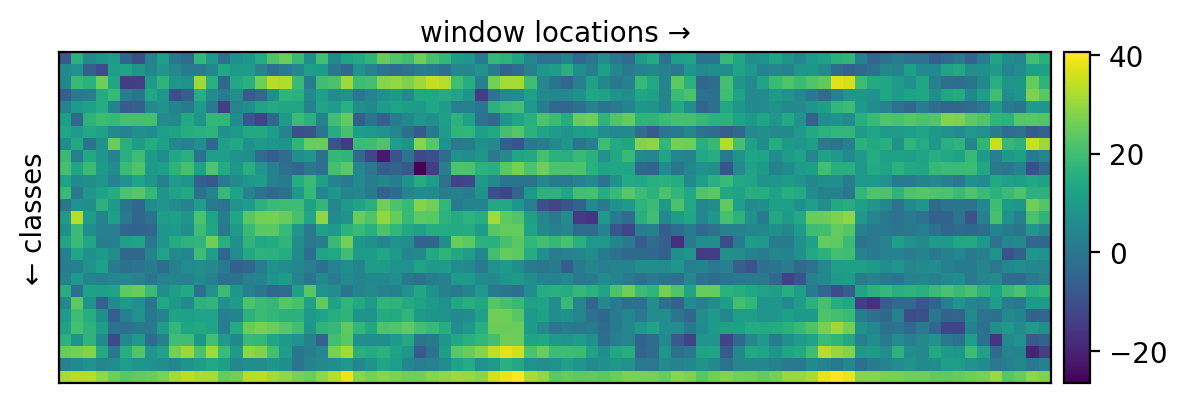

In [59]:
alphabet_energies_post_train = model(alphabet.cuda().view(1, 1, *alphabet.shape))
plot_energies(alphabet_energies_post_train[0].detach())


Question: Explain any classes that are lit up. What is still missing to be able to use it for transcription of words?

Answer:

One of the most significant observations from the energy plot is that the last class, which likely corresponds to a "space" or blank character, appears brighter (higher energy values) across many window locations. This behavior is expected because the model was trained exclusively on single-character inputs without explicitly learning to recognize or differentiate "space" characters.

Additionally, the model appears to struggle with distinguishing certain letter classes like 'i', 'l', and 't', based on their energy values. This is likely due to these letters having similar visual features, making it challenging for the model to separate them effectively.

To make the model suitable for transcribing sequences of characters (such as full words), it would need to be trained with examples that include spaces and sequences of multiple characters. The model outputs energy values for each class at different window locations, but we need a way to convert these outputs into a coherent sequence of characters (decoding). Furthermore, during training, the model would also need to learn the optimal window size for processing variable-width input images, ensuring that it can adapt to different character spacings and input lengths.

## Training with multiple characters

Now, we want to train our model to not only recognize the letters, but also to recognize space in-between so that we can use it for transcription later.

This is where complications begin. When transcribing a word from an image, we don't know beforehand how long the word is going to be. We can use our convolutional neural network we've pretrained on single characters to get prediction of character probabilities for all the positions of an input window in the new input image, but we don't know beforehand how to match those predictions with the target label. Training with incorrect matching can lead to wrong model, so in order to be able to train a network to transcribe words, we need a way to find these pairings.

![dl.png](https://i.imgur.com/7pnodfV.png)

The importance of pairings can be demonstrated by the drawing above. If we map $l_1, l_2, l_3, l_4$ to 'c', 'a', 't', '_' respectively, we'll correctly train the system, but if we put $l_1, l_2, l_3, l_4$ with 'a', 'a', 't', 't', we'd have a very wrong classifier.

To formalize this, we use energy-based models' framework. Let's define the energy $E(x, y, z)$ as the sum of cross-entropies for a particular pairing between probabilities our model gives for input image $x$ and text transcription $y$, and pairing $z$. $z$ is a function $z : \{1, 2, \dots, \vert l \vert \} \to \{1, 2, \dots, \vert y \vert)$, $l$ here is the energies output of our convolutional neural net $l = f_\theta(x)$. $z$ maps each energy vector in $l$ to an element in the output sequence $y$. We want the mappings to make sense, so $z$ should be a non-decreasing function $z(i) \leq z(i+1)$, and it shouldn't skip characters, i.e. $\forall_i \exists_j z(j)=i$.

Energy is then $E(x, y, z) = C(z) + \sum_{i=1}^{\vert l \vert} l_i[z(i)]$
,  $C(z)$ is some extra term that allows us to penalize certain pairings, and $l_i[z(i)]$ is the energy of $z(i)$-th symbol on position $i$.

In this particular context, we define $C(z)$ to be infinity for impossible pairings:
$$C(z) = \begin{cases}
\infty \; \text{if} \; z(1) \neq 1 \vee z(\vert l \vert) \neq \vert y \vert \vee \exists_{i, 1\leq 1 \leq \vert l \vert - 1} z(i) > z(i+1) \vee z(i) < z(i+1) - 1\\
0 \; \text{otherwise}
\end{cases}
$$


Then, the free energy $F(x, y) = \arg \min_z E(x, y, z)$. In other words, the free energy is the energy of the best pairing between the probabilities provided by our model, and the target labels.

When training, we are going to use cross-entropies along the best path: $\ell(x, y, z) = \sum_{i=1}^{\vert l \vert}H(y_{z(i)}, \sigma(l_i))$, where $H$ is cross-entropy, $\sigma$ is soft-argmin needed to convert energies to a distribution.

First, let's write functions that would calculate the needed cross entropies $H(y_{z(i)}, \sigma(l_i))$, and energies for us.

In [60]:
def build_path_matrix(energies, targets):
    # inputs:
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \vert l \vert
    # T is \vert y \vert
    #
    # outputs:
    #    a matrix of shape BATCH_SIZE x L x T
    #    where output[i, j, k] = energies[i, j, targets[i, k]]
    #    intuition: output[i, j, k] gives you the energy of matching jth feature with the kth target character
    #
    # Note: you're not allowed to use for loops. The calculation has to be vectorized.
    # you may want to use repeat and repeat_interleave.
    # TODO
    BATCH_SIZE, L, _ = energies.shape
    T = targets.shape[1]
    targets_expanded = targets.unsqueeze(1).repeat(1, L, 1)
    path_matrix = torch.gather(energies, 2, targets_expanded)
    return path_matrix

def build_ce_matrix(energies, targets):
    # inputs:
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \ververtt = targets.unsqueeze(1).repeat(1,energies.shape[1],1)t l \vert
    # T is \vert y \vert
    #
    # outputs:
    #    a matrix ce of shape BATCH_SIZE x L x T
    #    where ce[i, j, k] = cross_entropy(energies[i, j], targets[i, k])
    #
    # Note: you're not allowed to use for loops. The calculation has to be vectorized.
    # you may want to use repeat and repeat_interleave.
    # TODO
    BATCH_SIZE, L, _ = energies.shape
    _, T = targets.shape
    targets_expanded = targets.unsqueeze(1).expand(-1, L, -1)
    energies_expanded = energies.unsqueeze(2).expand(-1, -1, T, -1)
    energies_flat = energies_expanded.reshape(BATCH_SIZE * L * T, 27)
    targets_flat = targets_expanded.reshape(BATCH_SIZE * L * T)
    ce_flat = cross_entropy(energies_flat, targets_flat, reduction='none')
    ce = ce_flat.view(BATCH_SIZE, L, T)
    return ce

# code to test your implementation
for _ in range(10):
    energies = torch.randn(8, 20, ALPHABET_SIZE)
    targets = torch.randint(ALPHABET_SIZE, (8, 15))
    pm = build_path_matrix(energies, targets)

    b = random.randint(0, energies.shape[0] - 1)
    i = random.randint(0, energies.shape[1] - 1)
    j = random.randint(0, targets.shape[1] - 1)
    assert pm[b, i, j] == energies[b, i, targets[b, j]]

    ce = build_ce_matrix(energies, targets)

    assert ce[b, i, j] == cross_entropy(energies[b, i].unsqueeze(0),
                                        targets[b, j].to(energies.device).unsqueeze(0))

Another thing we will need is a transformation for our label $y$. We don't want to use it as is, we want to insert some special label after each character, so, for example 'cat' becomes 'c_a_t_'. This extra '\_' models the separation between characters, allowing our model to distinguish between strings 'aa' and 'a' in its output. This is then used in inference - we can just get the most likely character for each position from $l = f_\theta(x)$ (for example 'aa_bb_ccc_'), and then remove duplicate characters ('a_b_c_'), and then remove _ (abc).
Let's implement a function that would change the string in this manner, and then map all characters to values from 0 to 26, with 0 to 25 corresponding to a-z, and 26 corresponding to _:

In [61]:
def transform_word(s):
    # input: a string
    # output: a tensor of shape 2*len(s)
    # TODO
    char_to_idx = {char: idx for idx, char in enumerate(string.ascii_lowercase + '_')}
    word_with_underscores = '_'.join(s) + '_'
    mapped_indices = [char_to_idx[char] for char in word_with_underscores]
    return torch.tensor(mapped_indices)

Now, let's plot energy table built on our model's prediction for alphabet image.

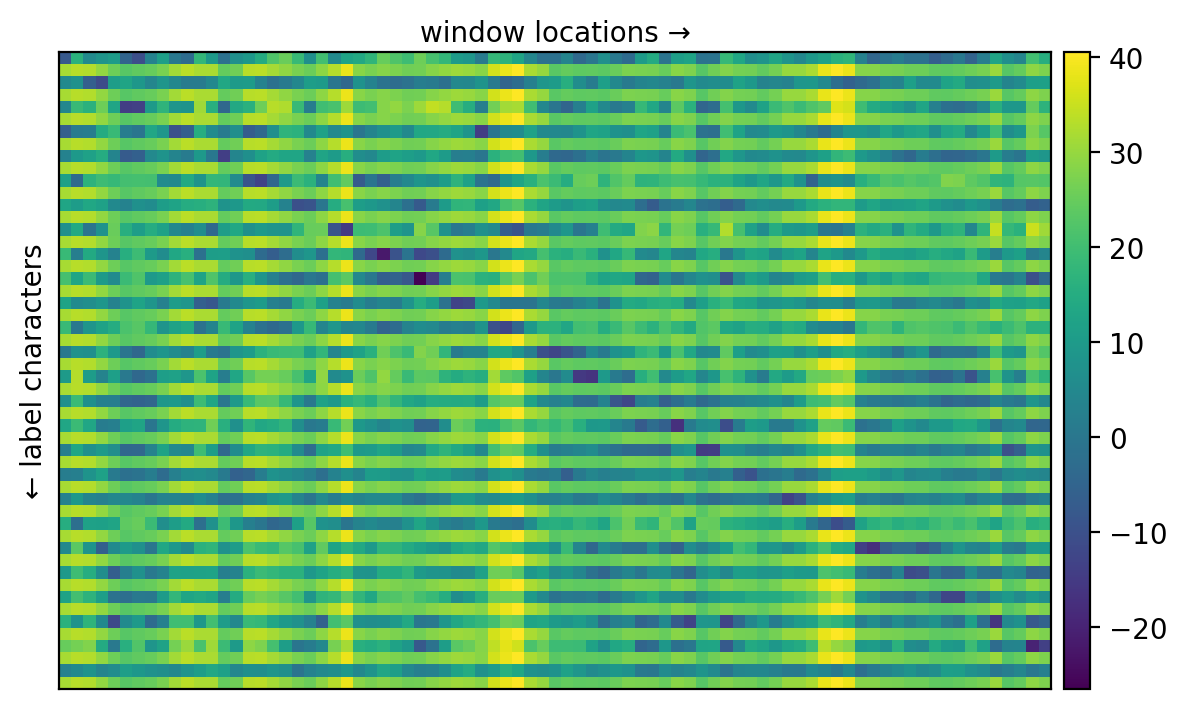

In [62]:
def plot_pm(pm, path=None):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(pm.cpu().T)

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← label characters')
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks([])

    if path is not None:
        for i in range(len(path) - 1):
            ax.plot(*path[i], *path[i+1], marker = 'o', markersize=0.5, linewidth=10, color='r', alpha=1)

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)

energies = model(alphabet.cuda().view(1, 1, *alphabet.shape)) # [1, k, 27]
targets = transform_word(string.ascii_lowercase).unsqueeze(0).cuda() # [1, 26 * 2]

pm = build_path_matrix(energies, targets)
plot_pm(pm[0].detach())

Question: What do you see? What does the model classify correctly, and what does it have problems with?

Answer:

We see low-energies along the diagonal. The model was trained only on single character alphabet inputs, meaning it learned to recognize individual letters but was not explicitly trained to handle spaces or separators that we defined in transform_word function. That is the reason we see the last row lit up and other rows having some low-energy window locations (giving the accurate character results) with an alternating low-energy high-energy row pattern for space characters in between letters. We still don't know a deterministic way to map the best window to the character accurately.

Question: Searching for a good pairing $z$ is same as searching for a trajectory with a small sum of it's values in this `pm` matrix. Where does the trajectory start, and where does it end? What other properties does the trajectory have? Can you see where an optimal trajecotry would be passing through in the plot above?

Answer:

The trajectory starts at the top-left corner of the path matrix, which corresponds to the first window location (along the x-axis) and the first label character (along the y-axis). In other words, it starts at (0,0). This aligns with the constraint $z(1) = 1$, meaning the first mapping in the sequence must align with the start of the target transcription.

The trajectory ends at the bottom-right corner of the matrix, corresponding to the last window location and the last label character. This means it ends at $(L-1, T-1)$ where $L$ is the number of window locations and $T$ is the length of the transformed target sequence. This satisfies the constraint $z(|l|) = |y|$.

The trajectory must move from left to right and top to bottom, meaning that it should not move backward. This corresponds to the requirement that the mapping function $z(i) \leq z(i+1)$. In terms of the plot, this means the trajectory should always move right or down, never left or up. The trajectory should not skip over characters. That is, it should move to the next row or column without jumping over multiple rows or columns.

In the path matrix plot, the optimal trajectory would pass through regions of lower energy, where the model is more confident in matching the window location with the corresponding label character. The trajectory would follow a zigzag pattern, moving down and right while staying within the lower-energy regions corresponding to the correctly identified characters.

Now let's implement a function that would tell us the energy of a particular path (i.e. pairing).

In [63]:
def path_energy(pm, path):
    # inputs:
    #   pm - a matrix of energies (L, T)
    #    L - energies length
    #    T - targets length
    #   path - list of length L tuples that maps each energy vector to an element in T
    # returns:
    #   energy - sum of energies on the path, or 2**30 if the mapping is invalid
    # TODO
    L, T = pm.shape
    if path[0] != 0 or path[-1] != T - 1:
        return torch.tensor(2**30)
    total_energy = 0
    previous_column = 0
    for row, col in enumerate(path):
        if col < previous_column or col > previous_column + 1:
            return torch.tensor(2**30)
        total_energy += pm[row, col]
        previous_column = col
    return torch.tensor(total_energy)

Now we can check some randomly generated paths and see the associated energies for our alphabet image:

<ipython-input-63-9de3449cd263>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(total_energy)


energy is 1070.4964599609375


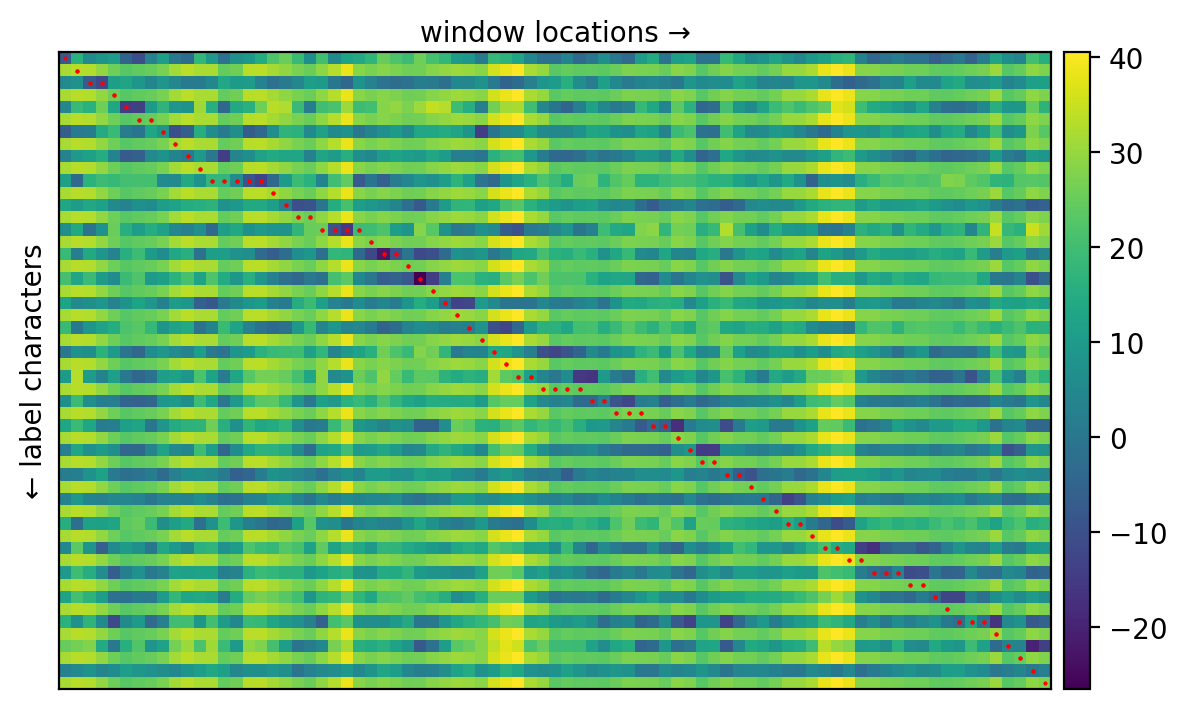

In [64]:
path = torch.zeros(energies.shape[1] - 1) # [L - 1]
path[:targets.shape[1] - 1] = 1
path = [0] + list(map(lambda x : x.int().item(), path[torch.randperm(path.shape[0])].cumsum(dim=-1)))
points = list(zip(range(energies.shape[1]), path))

plot_pm(pm[0].detach(), points)
print('energy is', path_energy(pm[0], path).item())

## Part - 1\: Viterbi

### Optimal path finding
Now, we're going to implement the finding of the optimal path. To do that, we're going to use Viterbi algorithm, which in this case is a simple dynamic programming problem.
In this context, it's a simple dynamic programming algorithm that for each pair i, j, calculates the minimum cost of the path that goes from 0-th index in the energies and 0-th index in the target, to i-th index in the energies, and j-th index in the target. We can memorize the values in a 2-dimensional array, let's call it `dp`. Then we have the following transitions:
```
dp[0, 0] = pm[0, 0]
dp[i, j] = min(dp[i - 1, j], dp[i - 1, j - 1]) + pm[i, j]
```

The optimal path can be recovered if we memorize which cell we came from for each `dp[i, j]`.

Below, you'll need to implement this algorithm:

In [65]:
def find_path(pm):
    # inputs:
    #   pm - a tensor of shape LxT with energies
    #     L is length of energies array
    #     T is target sequence length
    # NOTE: this is slow because it's not vectorized to work with batches.
    #  output:
    #     a tuple of three elements:
    #         1. sum of energies on the best path,
    #         2. list of tuples - points of the best path in the pm matrix
    #         3. the dp array

    # TODO
    L, T = pm.shape
    dp = torch.full((L, T), float('inf'))
    dp[0, 0] = pm[0, 0]
    path_tracker = [[[] for _ in range(T)] for _ in range(L)]
    path_tracker[0][0] = [(0, 0)]
    for i in range(1, L):
        for j in range(T):
            if j == 0 or dp[i - 1, j] <= dp[i - 1, j - 1]:
                dp[i, j] = dp[i - 1, j] + pm[i, j]
                path_tracker[i][j] = path_tracker[i - 1][j] + [(i, j)]
            else:
                dp[i, j] = dp[i - 1, j - 1] + pm[i, j]
                path_tracker[i][j] = path_tracker[i - 1][j - 1] + [(i, j)]
    total_energy = dp[L - 1, T - 1]
    best_path = path_tracker[L - 1][T - 1]
    return total_energy, best_path, dp

Let's take a look at the best path:

free energy is 174.98004150390625


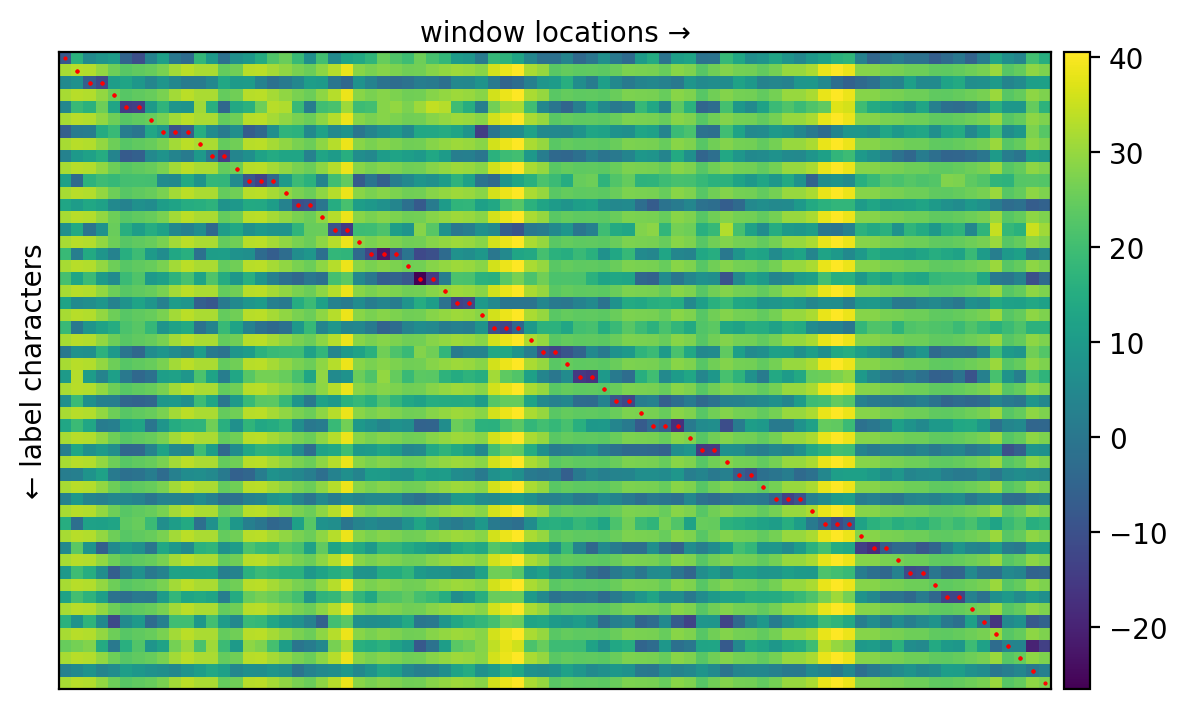

In [66]:
free_energy, path, d = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

We can also visualize the dp array. You may need to tune clamping to see what it looks like.

(-0.5, 80.5, 51.5, -0.5)

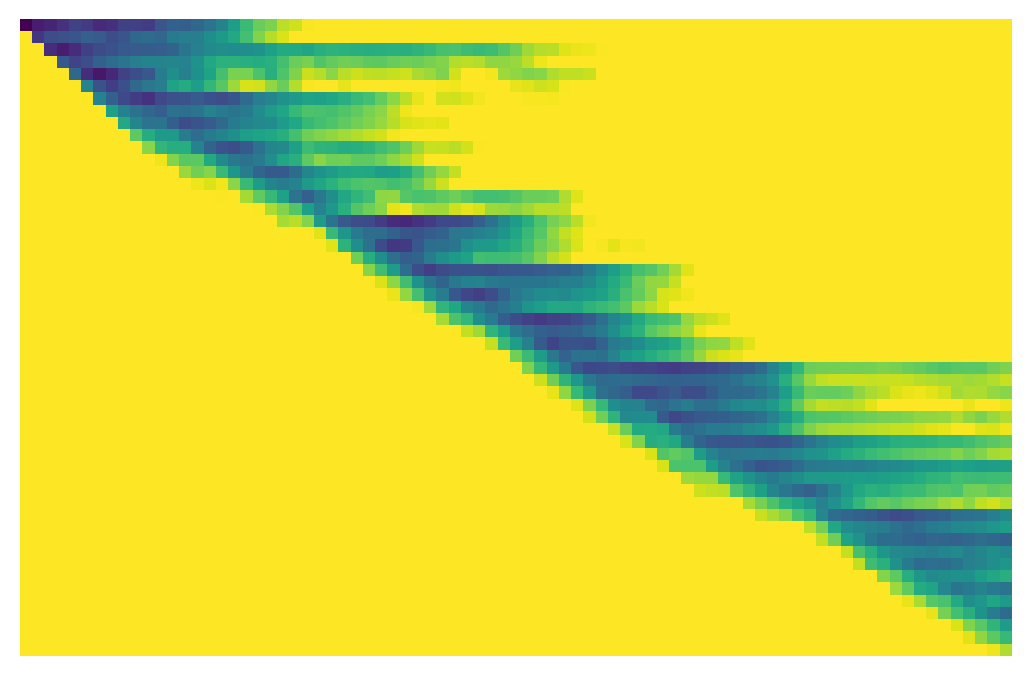

In [67]:
plt.figure(dpi=200)
plt.imshow(d.cpu().detach().T.clamp(torch.min(d).item(), 200))
plt.axis('off')

### Training loop
Now is time to train the network using our best path finder. We're going to use the energy loss function:
$$\ell(x, y) = \sum_i H(y_{z(i)}, l_i)$$
Where $z$ is the best path we've found. This is akin to pushing down on the free energy $F(x, y)$, while pushing up everywhere else by nature of cross-entropy.

In [68]:
def path_cross_entropy(ce, path):
    # to be used in train_ebm_model below
    # inputs:
    #   ce - a matrix of cross entropy
    #    L - energies length
    #    T - targets length
    #   path - list of length L tuples (l, t) that tracks the optimal path
    # returns:
    #   total cross entropy of best path

    # TODO
    total_ce = 0.0
    for (i, j) in path:
        total_ce += ce[i, j]
    return total_ce

In [69]:
def train_ebm_model(model, num_epochs, train_loader, criterion, optimizer):
    ''' Train EBM Model using find_path()'''
    pbar = tqdm(range(num_epochs))
    total_train_loss = 0.0
    size = 0
    free_energies = []
    paths = []
    model.train()
    for epoch in pbar:
        start_time = time.time()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            batch_loss = 0.0
            for idx in range(outputs.size(0)):
                path_matrix = build_path_matrix(outputs[idx].unsqueeze(0), labels[idx].unsqueeze(0))
                _, best_path, _ = find_path(path_matrix[0])
                ce_matrix = build_ce_matrix(outputs[idx].unsqueeze(0), labels[idx].unsqueeze(0))
                path_ce_loss = path_cross_entropy(ce_matrix[0], best_path)
                batch_loss += path_ce_loss
            batch_loss.backward()
            optimizer.step()
            total_train_loss += batch_loss.item()
        epoch_time = time.time() - start_time
        pbar.set_postfix({'train_loss': total_train_loss / len(sds), 'Epoch Time': epoch_time})
    return

In [70]:
import copy
import time

def collate_fn(samples):
    """ A function to collate samples into batches for multi-character case"""
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(transform_word, annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    m_length = max(3, max([s.shape[0] for s in annotations]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        annotations[i] = torch.nn.functional.pad(annotations[i], (0, m_length - annotations[i].shape[0]), value=BETWEEN)
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

# TODO: 1. Create SimpleNet() model
#          To simplify the task, you can initialize the model with
#          the weights of single-character model. That would incur a 5 points
#          penalty though.
#       2. Initialize optimizer
#       3. Train the model
# note: remember that our best path finding algorithm is not batched, so you'll
# need a for loop to do loss calculation.
# This is not ideal, as for loops are very slow, but for
# demonstration purposes it will suffice. In practice, this will be
# unusable for any real problem unless it handles batching.
# also: remember that the loss is the sum of cross_entropies along the path, not
# energies!

model = SimpleNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = cross_entropy

# Train the model
train_ebm_model(model, num_epochs=5, train_loader=dataloader, criterion=criterion, optimizer=optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

Let's check what the energy matrix looks like for the alphabet image now.

free energy is -795.149169921875


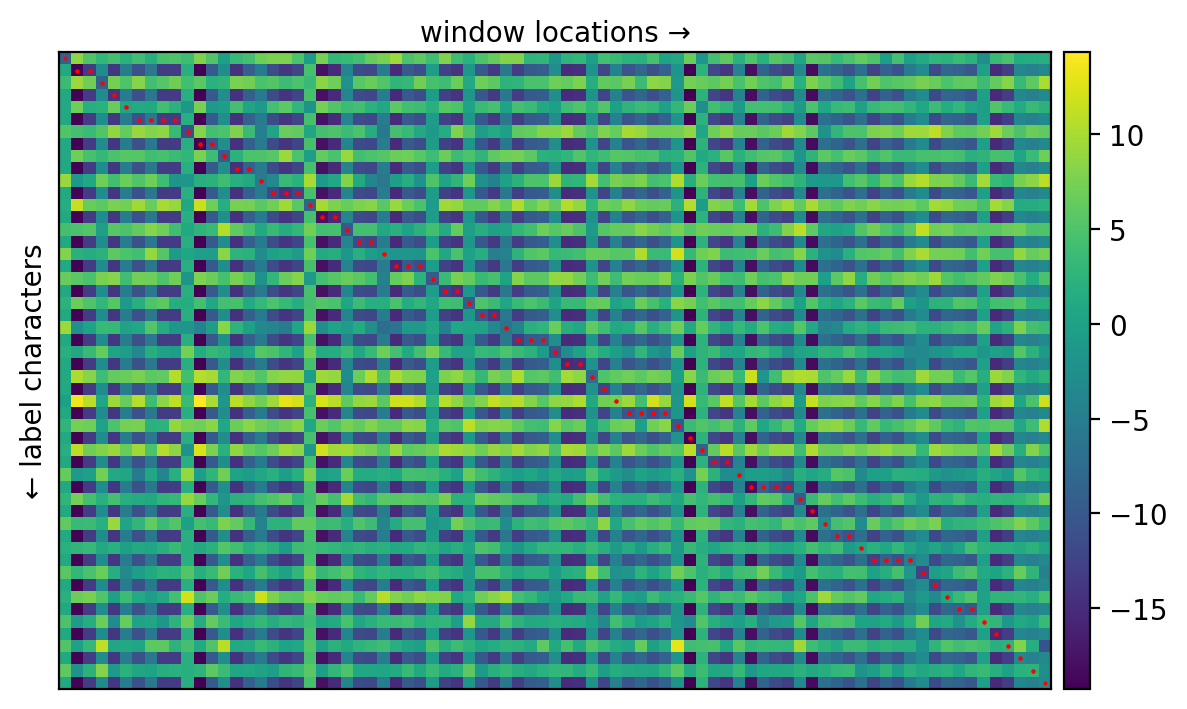

In [71]:
ebm_model = model
energies = ebm_model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase).cuda()
pm = build_path_matrix(energies, targets.unsqueeze(0))

free_energy, path, _ = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

Question: Explain how the free energy changed, and why.

Answer:

The decrease in free energies is not confined to just the diagonal region; instead, it extends across the entire matrix. This behavior can be explained by the influence of the optimal alignment path. As the optimal path traverses the matrix, it affects the energy values along its trajectory, leading to a reduction in the energy values in surrounding regions as well. The path's influence effectively "pulls down" the energy values, making lower energy areas more prominent throughout the matrix, not just along the direct path of alignment.

We can also look at raw energies output:

(-0.5, 80.5, 26.5, -0.5)

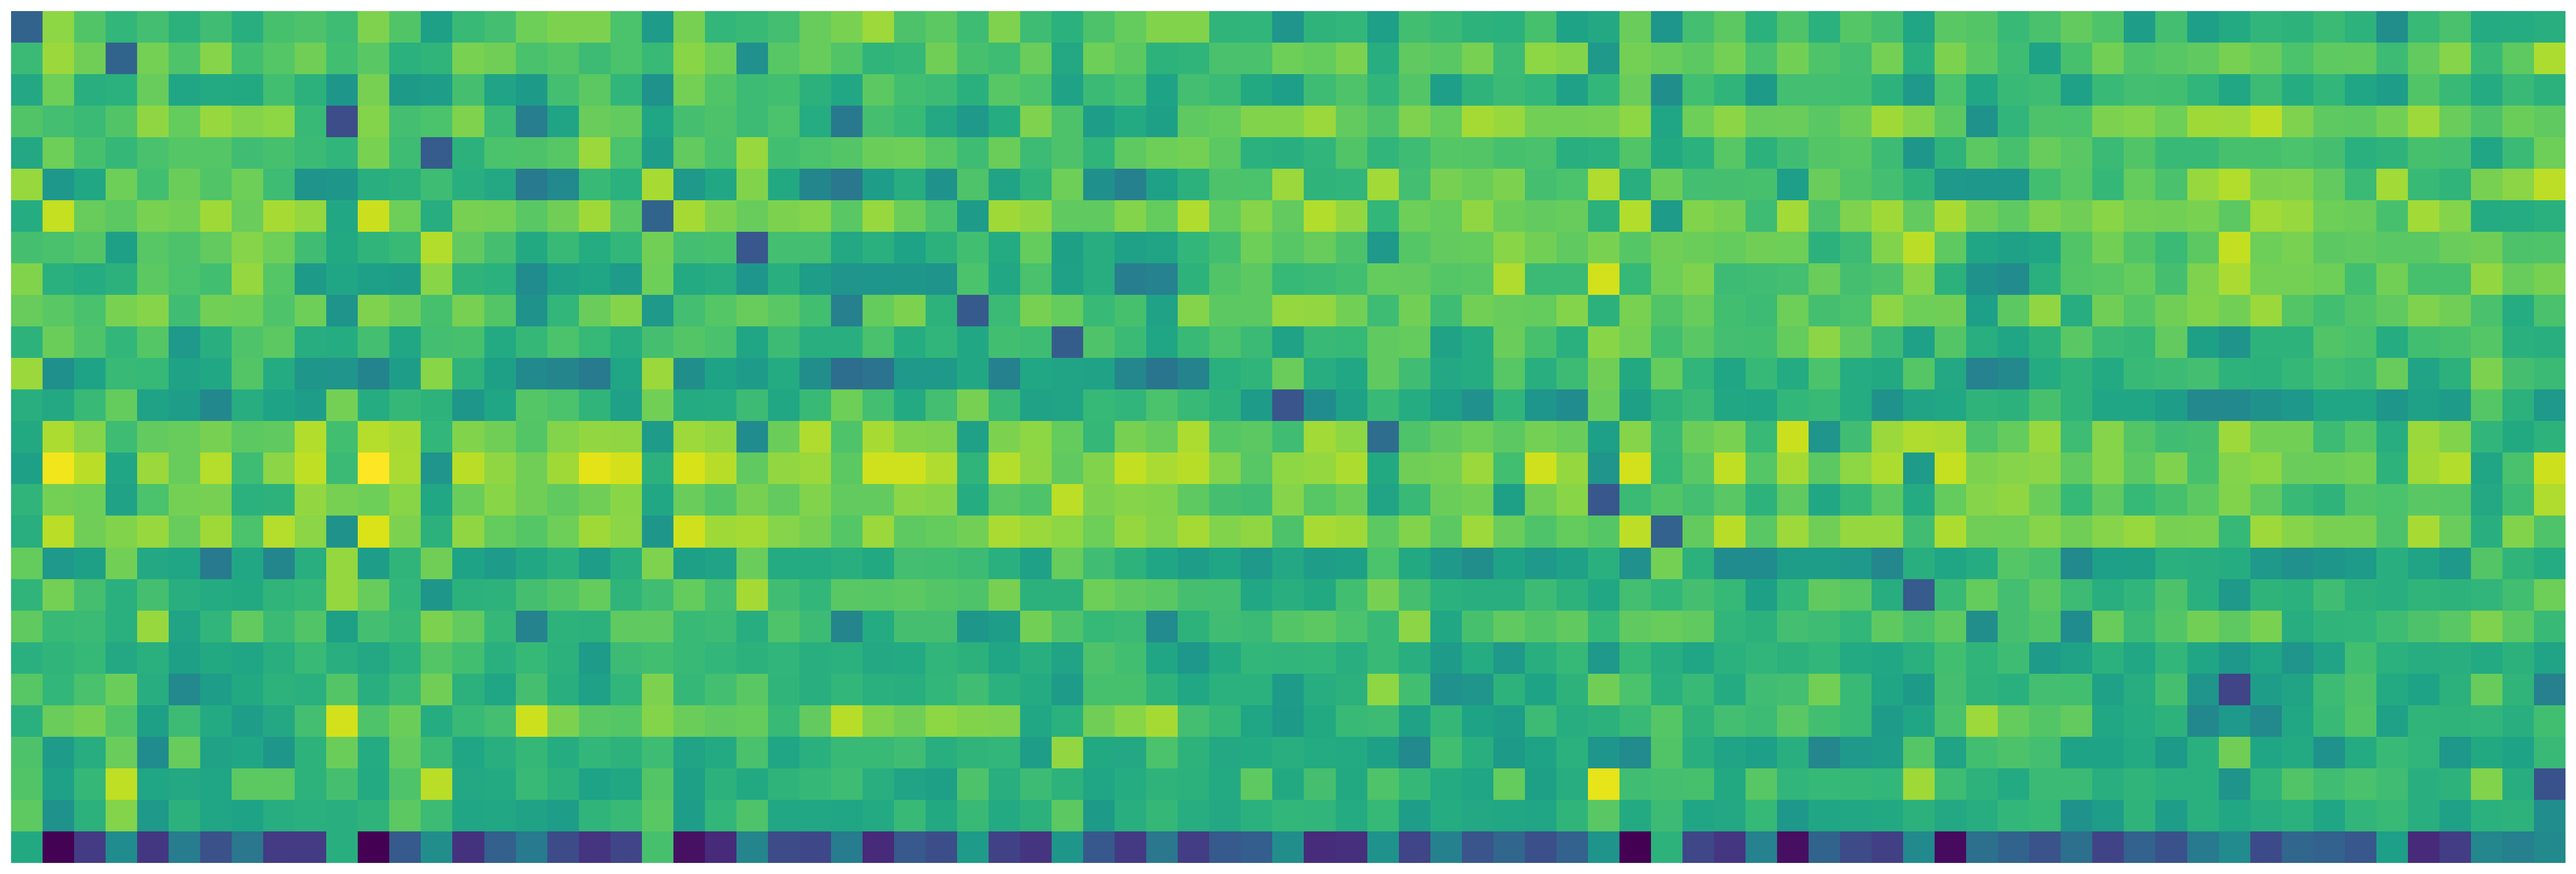

In [72]:
alphabet_energy_post_train_viterbi = ebm_model(alphabet.cuda().view(1, 1, *alphabet.shape))

plt.figure(dpi=200, figsize=(40, 10))
plt.imshow(alphabet_energy_post_train_viterbi.cpu().data[0].T)
plt.axis('off')

Question: How does this compare to the energies we had after training only on one-character dataset?

Answer:

The energy levels in the last row of the matrix are notably lower, and the diagonal region is a more darker shade of blue, indicating areas with lower energy values. This pattern aligns with the nature of our input, which is the ordered alphabet. Since the input follows a sequential order, the model is more confident in matching the corresponding characters along the diagonal path. As a result, the energy values are lower in this region, reflecting the model's higher confidence in correctly aligning the input with the target sequence.

## Decoding

Now we can use the model for decoding a word from an image. Let's pick some word, apply the model to it, and see energies.

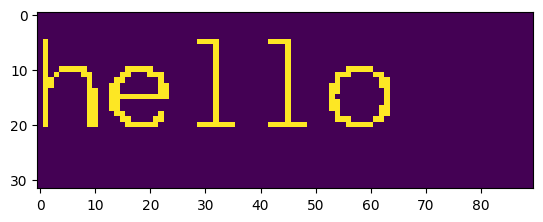

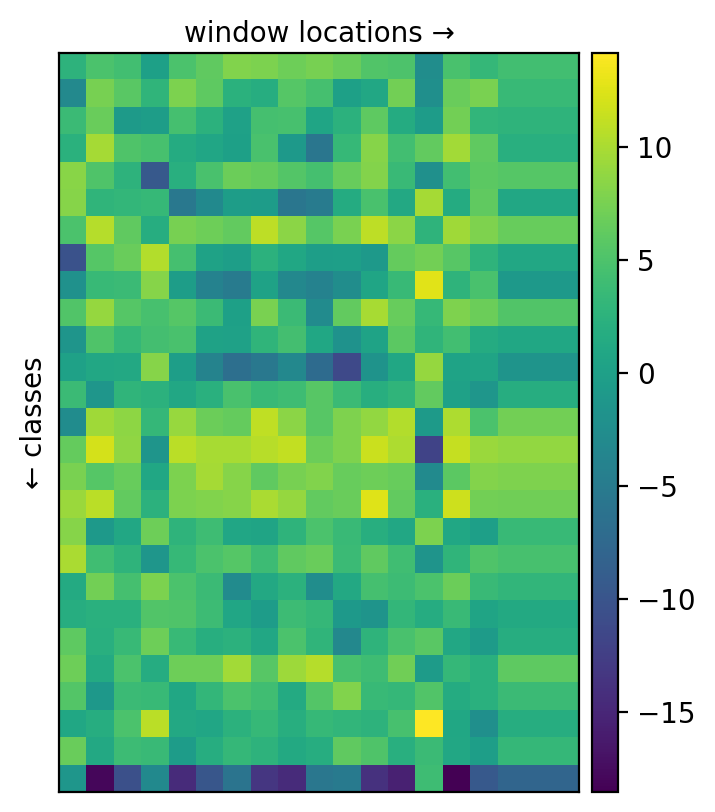

In [73]:
img = sds.draw_text('hello')
energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

You should see some characters light up. Now, let's implement a simple decoding algorithm. To decode, first we want to get most likely classes for all energies, and then do two things:
1. segment strings using the divisors (our special character with index 26), and for each segment replace it with the most common character in that segment. Example: aaab_bab_ -> a_b. If some characters are equally common, you can pick random.
2. remove all special divisor characters: a_b -> ab


In [74]:
def indices_to_str(indices):
    # inputs: indices - a tensor of most likely class indices
    # outputs: decoded string
    result = ''.join(
    chr(idx + ord('a')) for i, idx in enumerate(indices)
    if idx != 26 and (i == 0 or indices[i - 1] == 26))
    return result

min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

hello


## Part - 2\: GTN (Extra Credits, 10pts)

### CTC Loss Function

The below cell has the CTC Loss implementation which will be needed for the training. It also has the viterbi implemented, so feel free to use it.

- For calculating loss, `CTCLoss()` can be used.
- For viterbi, `CTCLossFunction.viterbi()` can be used.

### Brief Explanation\:

GTN constructs 2 graphs-
1. Alignment graph $A_y$ that can produce a sequence of any length which when collapsed gives the output.
2. Emission graph $\mathcal{E}$ that can produce any sequence of length `L`, input's length. This can be considered as some sort of restriction over $A_y$.

Loss function is then calculated as $-\log P(y \mid X) = -(\log (A_y \circ \mathcal{E}) - \log \mathcal{E})$ where $\circ$ is the composition function.

In [ ]:
!pip install gtn==0.0.0

In [ ]:
# Credits: Adapted from https://github.com/facebookresearch/gtn_applications

import gtn

class CTCLossFunction(torch.autograd.Function):
    @staticmethod
    def create_ctc_graph(target, blank_idx):
        g_criterion = gtn.Graph(False)
        L = len(target)
        S = 2 * L + 1
        for l in range(S):
            idx = (l - 1) // 2
            g_criterion.add_node(l == 0, l == S - 1 or l == S - 2)
            label = target[idx] if l % 2 else blank_idx
            g_criterion.add_arc(l, l, label)
            if l > 0:
                g_criterion.add_arc(l - 1, l, label)
            if l % 2 and l > 1 and label != target[idx - 1]:
                g_criterion.add_arc(l - 2, l, label)
        g_criterion.arc_sort(False)
        return g_criterion

    @staticmethod
    def forward(ctx, log_probs, targets, blank_idx=0, reduction="none"):
        B, T, C = log_probs.shape
        losses = [None] * B
        scales = [None] * B
        emissions_graphs = [None] * B

        def process(b):
            # create emission graph
            g_emissions = gtn.linear_graph(T, C, log_probs.requires_grad)
            cpu_data = log_probs[b].cpu().contiguous()
            g_emissions.set_weights(cpu_data.data_ptr())

            # create criterion graph
            g_criterion = CTCLossFunction.create_ctc_graph(targets[b], blank_idx)
            # compose the graphs
            g_loss = gtn.negate(
                gtn.forward_score(gtn.intersect(g_emissions, g_criterion))
            )

            scale = 1.0
            if reduction == "mean":
                L = len(targets[b])
                scale = 1.0 / L if L > 0 else scale
            elif reduction != "none":
                raise ValueError("invalid value for reduction '" + str(reduction) + "'")

            # Save for backward:
            losses[b] = g_loss
            scales[b] = scale
            emissions_graphs[b] = g_emissions

        gtn.parallel_for(process, range(B))

        ctx.auxiliary_data = (losses, scales, emissions_graphs, log_probs.shape)
        loss = torch.tensor([losses[b].item() * scales[b] for b in range(B)])
        return torch.mean(loss.cuda() if log_probs.is_cuda else loss)

    @staticmethod
    def backward(ctx, grad_output):
        losses, scales, emissions_graphs, in_shape = ctx.auxiliary_data
        B, T, C = in_shape
        input_grad = torch.empty((B, T, C))

        def process(b):
            gtn.backward(losses[b], False)
            emissions = emissions_graphs[b]
            grad = emissions.grad().weights_to_numpy()
            input_grad[b] = torch.from_numpy(grad).view(1, T, C) * scales[b]

        gtn.parallel_for(process, range(B))

        if grad_output.is_cuda:
            input_grad = input_grad.cuda()
        input_grad *= grad_output / B

        return (
            input_grad,
            None,  # targets
            None,  # blank_idx
            None,  # reduction
        )

def viterbi(energies, targets, blank_idx=0):
    outputs = -1 * energies
    B, T, C = outputs.shape
    paths = [None] * B
    scores = [None] * B
    emissions_graphs = [None] * B
    def process(b):
        L = len(targets[b])
        # create emission graph
        g_emissions = gtn.linear_graph(T, C, outputs.requires_grad)
        cpu_data = outputs[b].cpu().contiguous()
        g_emissions.set_weights(cpu_data.data_ptr())

        # create criterion graph
        g_criterion = CTCLossFunction.create_ctc_graph(targets[b], blank_idx)
        g_score = gtn.viterbi_score(gtn.intersect(g_emissions, g_criterion))
        g_path = gtn.viterbi_path(gtn.intersect(g_emissions, g_criterion))
        paths[b] = [2*p if 2*p < L else i for i, p in enumerate(g_path.labels_to_list())]
        l = 0
        paths[b] = []
        for p in g_path.labels_to_list():
            if 2*p < L:
                l = p
                paths[b].append(2*p)
            else:
                paths[b].append(2*l + 1)
        scores[b] = -1 * g_score.item()
        emissions_graphs[b] = g_emissions

    gtn.parallel_for(process, range(B))

    return (scores, paths)

CTCLoss = CTCLossFunction.apply

In [ ]:
def train_gtn_model(model, num_epochs, train_loader, criterion, optimizer):
    ''' Train CTC Model using GTN'''
    pbar = tqdm(range(num_epochs))
    train_losses = []
    total_train_loss = 0.0
    size = 0
    free_energies = []
    paths = []
    max_grad_norm = None
    if torch.cuda.is_available():
        model = model.cuda()
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    for epoch in pbar:
        # TODO: implement the training loop

        epoch_time = time.time() - start_time
        train_losses.append(total_train_loss)
        pbar.set_postfix({'train_loss': total_train_loss, 'Epoch Time': epoch_time})

    return

In [ ]:
# Similar to what we have done earlier but instead of find_path(), we will use
# GTN's framework.
sds = SimpleWordsDataset(3, 2500) # for simplicity, we're training only on words of length three

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

# TODO: 1. Make another copy of the single character model and initialize optimizer
# TODO: 2. Train the model
# TODO: 1. Create SimpleNet() model
#          To simplify the task, you can initialize the model with
#          the weights of single-character model. That would incur a 5 points
#          penalty though.
#       2. Initialize optimizer
#       3. Train the model
# also: remember that the loss is the sum of cross_entropies along the path, not
# energies!




Question: Which one of the training methods\: `train_ebm_model()`, `train_gtn_model()` is faster? Why do you think so?

Answer:


In [ ]:
energies = gtn_model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase).cuda()
pm = build_path_matrix(energies, targets.unsqueeze(0))

# TODO: Use the provided viterbi function to get score and path


# path is obtained from the above TODO
points = list(zip(range(energies.shape[1]), path))
plot_pm(pm[0].detach(), points)
print('energy is', score)


In [ ]:
img = sds.draw_text('hello')
energies = gtn_model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

In [ ]:
min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))